# Baseline Models Tutorial: Random Forest and SVR

This notebook demonstrates how to:
1. Build a Drug-Target Affinity (DTA) dataset from ChEMBL
2. Train baseline models (Random Forest and SVR) using Morgan fingerprints
3. Evaluate model performance
4. Make predictions on new molecules

## Table of Contents
1. [Setup and Installation](#setup)
2. [Building a Dataset](#building-dataset)
3. [Training Random Forest](#random-forest)
4. [Training SVR](#svr)
5. [Model Evaluation](#evaluation)
6. [Making Predictions](#predictions)
7. [Best Practices](#best-practices)

## 1. Setup and Installation {#setup}

First, ensure you have DTA-GNN installed. If not, install it:

```bash
pip install dta-gnn
```

Or install from source:
```bash
git clone https://github.com/gozsari/DTA-GNN.git
cd DTA-GNN
pip install -e .
```

**Note**: For this tutorial, you'll need either:
- A local ChEMBL SQLite database (recommended for speed), OR
- Internet connection to use the ChEMBL Web API

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# DTA-GNN imports
from dta_gnn.pipeline import Pipeline
from dta_gnn.models import train_random_forest_on_run, train_svr_on_run
from dta_gnn.models.predict import predict_with_random_forest, predict_with_svr
from dta_gnn.io.runs import create_run_dir
from dta_gnn.visualization import plot_activity_distribution, plot_split_sizes

# Set style for plots (with fallback for compatibility)
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    try:
        plt.style.use('seaborn')
    except OSError:
        plt.style.use('default')
sns.set_palette("husl")

print("✓ All imports successful!")

✓ All imports successful!


## 2. Building a Dataset {#building-dataset}

### Step 2.1: Choose Your Data Source

You have two options:

**Option A: SQLite Database (Recommended)**
- Fast and works offline
- Requires downloading ~5GB ChEMBL database
- Download: `dta_gnn setup --version 36 --dir ./chembl_dbs`

**Option B: Web API**
- No setup required
- Slower but convenient for small datasets
- Requires internet connection

### Step 2.2: Initialize the Pipeline

In [2]:
# Option A: Using SQLite database (recommended)
# Uncomment and adjust path if you have a local database
pipeline = Pipeline(
     source_type="sqlite",
     sqlite_path="../chembl_dbs/chembl_36.db"
)

# Option B: Using Web API (no setup required)
#pipeline = Pipeline(source_type="web")

print("✓ Pipeline initialized")

✓ Pipeline initialized


### Step 2.3: Create a Run Directory

Run directories help organize your experiments and ensure reproducibility. Each run gets a unique timestamped folder.

In [3]:
# Create a new run directory
run_dir = create_run_dir()
print(f"✓ Run directory created: {run_dir}")
print(f"  Full path: {run_dir.resolve()}")

✓ Run directory created: runs/20260125_140023
  Full path: /Users/ozsari/Documents/Codes/DTA-GNN/examples/runs/20260125_140023


### Step 2.4: Build the Dataset

Now let's build a DTA dataset for a specific target. We'll use **CHEMBL204** (Acetylcholinesterase) as an example.

**Key Parameters:**
- `target_ids`: List of ChEMBL target IDs
- `standard_types`: Activity types to include (IC50, Ki, Kd, etc.)
- `split_method`: How to split data (random, scaffold, or temporal)
- `test_size`: Fraction for test set (default: 0.2)
- `val_size`: Fraction for validation set (default: 0.1)

In [4]:
# Build the dataset
print("Building dataset... This may take a few minutes with Web API...")

df = pipeline.build_dta(
    target_ids=["CHEMBL204"],  # Acetylcholinesterase
    standard_types=["IC50", "Ki", "Kd"],  # Common binding affinity measures
    split_method="scaffold",  # Scaffold-aware splitting (prevents data leakage)
    test_size=0.2,
    val_size=0.1,
    output_path=str(run_dir / "dataset.csv"),
    featurize=False  # We'll featurize during model training
)

print(f"\n✓ Dataset built successfully!")
print(f"  Total samples: {len(df)}")
print(f"  Columns: {df.columns.tolist()}")
print(f"\n  Split distribution:")
print(df["split"].value_counts())
print(f"\n  Label statistics:")
print(df["label"].describe())

2026-01-25 14:00:27.738 | INFO     | dta_gnn.pipeline:build_dta:44 - Starting DTA build for targets: ['CHEMBL204']


Building dataset... This may take a few minutes with Web API...

✓ Dataset built successfully!
  Total samples: 7908
  Columns: ['molecule_chembl_id', 'target_chembl_id', 'pchembl_value', 'year', 'label', 'smiles', 'split']

  Split distribution:
split
train    5536
test     1564
val       807
Name: count, dtype: int64

  Label statistics:
count    7908.000000
mean        5.995439
std         1.662942
min         1.000000
25%         4.770000
50%         5.670000
75%         7.060000
max        12.455932
Name: label, dtype: float64


In [5]:
# Save compounds separately (required for model training)
compounds = df[["molecule_chembl_id", "smiles"]].drop_duplicates()
compounds.to_csv(run_dir / "compounds.csv", index=False)
print(f"✓ Saved {len(compounds)} unique compounds to compounds.csv")

✓ Saved 7908 unique compounds to compounds.csv


### Step 2.5: Visualize the Dataset

Let's explore the dataset to understand its distribution.

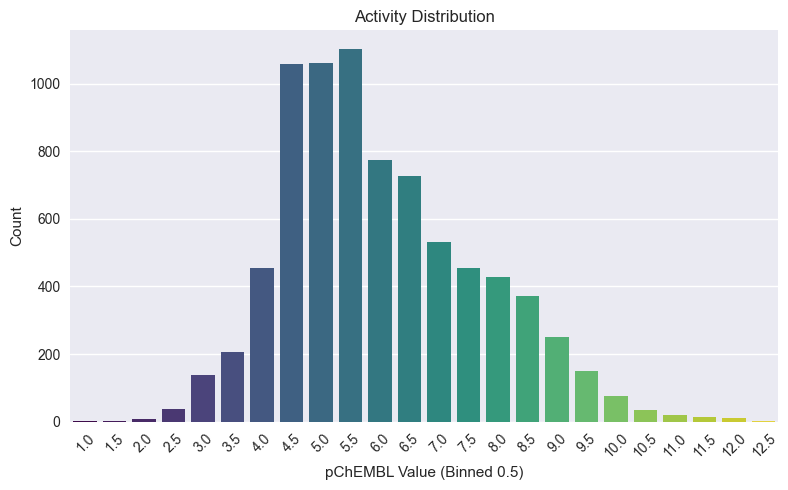

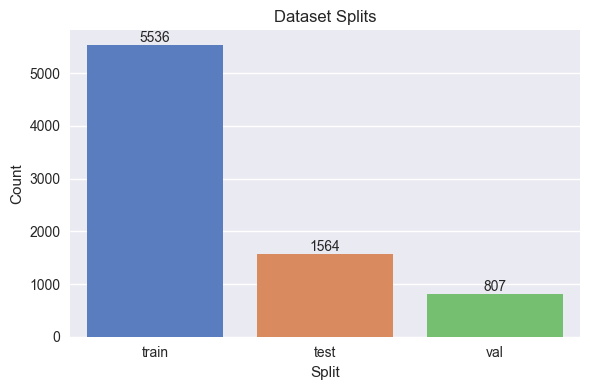


Sample data:
  molecule_chembl_id target_chembl_id    label  split
0       CHEMBL100013        CHEMBL204  5.00000  train
1       CHEMBL100067        CHEMBL204  5.00000  train
2       CHEMBL100109        CHEMBL204  9.62000  train
3       CHEMBL100181        CHEMBL204  6.52000  train
4       CHEMBL100187        CHEMBL204  7.80000  train
5       CHEMBL100320        CHEMBL204  5.51000   test
6       CHEMBL100333        CHEMBL204  5.00000    val
7       CHEMBL100619        CHEMBL204  5.00000    val
8       CHEMBL100666        CHEMBL204  5.00000  train
9       CHEMBL100672        CHEMBL204  7.30103    val


In [6]:
# Plot activity distribution
fig1 = plot_activity_distribution(df, title="Activity Distribution")
plt.show()

# Plot split sizes
fig2 = plot_split_sizes(df)
plt.show()

# Display sample data
print("\nSample data:")
print(df[["molecule_chembl_id", "target_chembl_id", "label", "split"]].head(10))

## 3. Training Random Forest {#random-forest}

Random Forest is a strong baseline model that uses **Morgan fingerprints (ECFP4)** as features.

**Advantages:**
- Fast training and inference
- Works well for both classification and regression
- No hyperparameter tuning needed for basic use
- Interpretable feature importance

**How it works:**
1. Converts SMILES to Morgan fingerprints (2048-bit vectors)
2. Trains a Random Forest ensemble
3. Automatically detects task type (classification vs regression)

In [7]:
# Train Random Forest model
print("Training Random Forest model...")

rf_result = train_random_forest_on_run(
    run_dir=run_dir,
    n_estimators=500,  # Number of trees in the forest
    random_seed=42
)

print(f"\n✓ Training completed!")
print(f"  Task type: {rf_result.task_type}")
print(f"  Model saved to: {rf_result.model_path}")
print(f"  Metrics saved to: {rf_result.metrics_path}")
print(f"  Predictions saved to: {rf_result.predictions_path}")

Training Random Forest model...

✓ Training completed!
  Task type: regression
  Model saved to: /Users/ozsari/Documents/Codes/DTA-GNN/examples/runs/20260125_140023/model_rf.pkl
  Metrics saved to: /Users/ozsari/Documents/Codes/DTA-GNN/examples/runs/20260125_140023/model_metrics.json
  Predictions saved to: /Users/ozsari/Documents/Codes/DTA-GNN/examples/runs/20260125_140023/model_predictions.csv


In [9]:
# Load and display metrics
import json

with open(rf_result.metrics_path, 'r') as f:
    metrics = json.load(f)

print("Model Performance Metrics:")
print("=" * 50)

if rf_result.task_type == "classification":
    for split_name, split_metrics in metrics.get("splits", {}).items():
        print(f"\n{split_name.upper()} Set:")
        print(f"  Accuracy: {split_metrics.get('accuracy', 'N/A'):.4f}")
        print(f"  ROC-AUC: {split_metrics.get('roc_auc', 'N/A'):.4f}")
        print(f"  Precision: {split_metrics.get('precision', 'N/A'):.4f}")
        print(f"  Recall: {split_metrics.get('recall', 'N/A'):.4f}")
        print(f"  F1-Score: {split_metrics.get('f1', 'N/A'):.4f}")
else:  # regression
    for split_name, split_metrics in metrics.get("splits", {}).items():
        print(f"\n{split_name.upper()} Set:")
        print(f"  RMSE: {split_metrics.get('rmse', 'N/A'):.4f}")
        print(f"  MAE: {split_metrics.get('mae', 'N/A'):.4f}")
        print(f"  R²: {split_metrics.get('r2', 'N/A'):.4f}")

Model Performance Metrics:

TRAIN Set:
  RMSE: 0.3089
  MAE: 0.2046
  R²: 0.9661

VAL Set:
  RMSE: 0.8369
  MAE: 0.6373
  R²: 0.6770

TEST Set:
  RMSE: 0.9337
  MAE: 0.6983
  R²: 0.6964


Available columns in predictions file: ['molecule_chembl_id', 'target_chembl_id', 'pchembl_value', 'year', 'label', 'smiles', 'split', 'y_pred']

Number of predictions: 2371


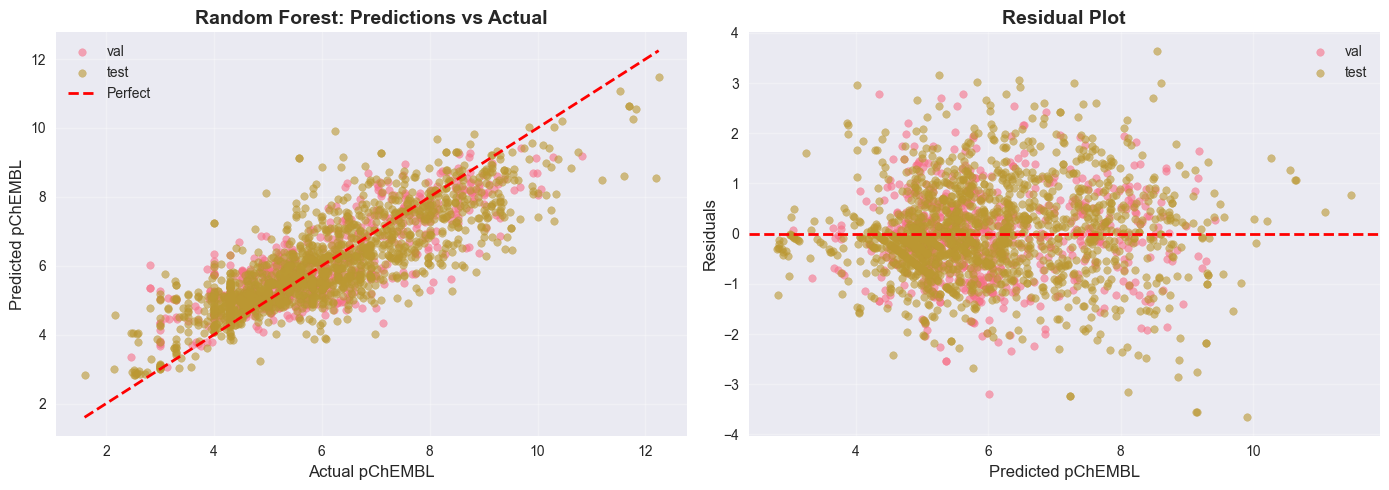

In [10]:
# Visualize predictions vs actual values
preds_df = pd.read_csv(rf_result.predictions_path)

# Check available columns (for debugging)
print("Available columns in predictions file:", preds_df.columns.tolist())
print(f"\nNumber of predictions: {len(preds_df)}")

if rf_result.task_type == "regression":
    # The predictions CSV contains 'label' (true values) and 'y_pred' (predictions)
    # Note: predictions file only contains val/test splits, not train
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot: predictions vs actual
    for split in ["val", "test"]:  # Only val and test are in predictions file
        split_data = preds_df[preds_df["split"] == split]
        if len(split_data) > 0:
            axes[0].scatter(
                split_data["label"],  # True values are in 'label' column
                split_data["y_pred"], 
                alpha=0.6, 
                label=split,
                s=30
            )
    
    # Perfect prediction line
    if len(preds_df) > 0:
        min_val = min(preds_df["label"].min(), preds_df["y_pred"].min())
        max_val = max(preds_df["label"].max(), preds_df["y_pred"].max())
        axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
    axes[0].set_xlabel("Actual pChEMBL", fontsize=12)
    axes[0].set_ylabel("Predicted pChEMBL", fontsize=12)
    axes[0].set_title("Random Forest: Predictions vs Actual", fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Residual plot
    for split in ["val", "test"]:
        split_data = preds_df[preds_df["split"] == split]
        if len(split_data) > 0:
            residuals = split_data["label"] - split_data["y_pred"]
            axes[1].scatter(
                split_data["y_pred"], 
                residuals, 
                alpha=0.6, 
                label=split,
                s=30
            )
    
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel("Predicted pChEMBL", fontsize=12)
    axes[1].set_ylabel("Residuals", fontsize=12)
    axes[1].set_title("Residual Plot", fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    # Classification: confusion matrix or ROC curve
    print("Classification task - check predictions.csv for detailed results")

## 4. Training SVR (Support Vector Regression) {#svr}

SVR is another baseline model that uses Morgan fingerprints. It's particularly useful for regression tasks.

**Advantages:**
- Good for non-linear relationships
- Memory efficient
- Works well with high-dimensional features

**Parameters:**
- `kernel`: Type of kernel (rbf, linear, poly, sigmoid)
- `C`: Regularization parameter (higher = less regularization)
- `epsilon`: Margin of tolerance for errors

In [11]:
# Train SVR model
print("Training SVR model...")

svr_result = train_svr_on_run(
    run_dir=run_dir,
    kernel="rbf",  # Radial Basis Function kernel (non-linear)
    C=10.0,  # Regularization parameter
    epsilon=0.1,  # Margin of tolerance
    random_seed=42
)

print(f"\n✓ Training completed!")
print(f"  Task type: {svr_result.task_type}")
print(f"  Model saved to: {svr_result.model_path}")
print(f"  Metrics saved to: {svr_result.metrics_path}")
print(f"  Predictions saved to: {svr_result.predictions_path}")

Training SVR model...

✓ Training completed!
  Task type: regression
  Model saved to: /Users/ozsari/Documents/Codes/DTA-GNN/examples/runs/20260125_140023/model_svr.pkl
  Metrics saved to: /Users/ozsari/Documents/Codes/DTA-GNN/examples/runs/20260125_140023/model_metrics_svr.json
  Predictions saved to: /Users/ozsari/Documents/Codes/DTA-GNN/examples/runs/20260125_140023/model_predictions_svr.csv


In [13]:
# Load and display SVR metrics
with open(svr_result.metrics_path, 'r') as f:
    svr_metrics = json.load(f)

print("SVR Performance Metrics:")
print("=" * 50)

for split_name, split_metrics in svr_metrics.get("splits", {}).items():
    print(f"\n{split_name.upper()} Set:")
    print(f"  RMSE: {split_metrics.get('rmse', 'N/A'):.4f}")
    print(f"  MAE: {split_metrics.get('mae', 'N/A'):.4f}")
    print(f"  R²: {split_metrics.get('r2', 'N/A'):.4f}")

# Compare with Random Forest
print("\n" + "=" * 50)
print("Comparison: Random Forest vs SVR")
print("=" * 50)

rf_test_metrics = metrics.get("splits", {}).get("test", {})
svr_test_metrics = svr_metrics.get("splits", {}).get("test", {})

print(f"\nTest Set Performance:")
print(f"  Random Forest R²: {rf_test_metrics.get('r2', 'N/A'):.4f}")
print(f"  SVR R²: {svr_test_metrics.get('r2', 'N/A'):.4f}")
print(f"  Random Forest RMSE: {rf_test_metrics.get('rmse', 'N/A'):.4f}")
print(f"  SVR RMSE: {svr_test_metrics.get('rmse', 'N/A'):.4f}")

SVR Performance Metrics:

TRAIN Set:
  RMSE: 0.2415
  MAE: 0.1301
  R²: 0.9793

VAL Set:
  RMSE: 0.7852
  MAE: 0.5940
  R²: 0.7157

TEST Set:
  RMSE: 0.8754
  MAE: 0.6569
  R²: 0.7331

Comparison: Random Forest vs SVR

Test Set Performance:
  Random Forest R²: 0.6964
  SVR R²: 0.7331
  Random Forest RMSE: 0.9337
  SVR RMSE: 0.8754


## 5. Making Predictions {#predictions}

Now let's use the trained models to make predictions on new molecules.

In [14]:
# Example SMILES strings for prediction
new_smiles = [
    "CCO",  # Ethanol
    "CC(=O)OC1=CC=CC=C1C(=O)O",  # Aspirin
    "CC1=CC=C(C=C1)C(C)CC(=O)O",  # Ibuprofen
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",  # Caffeine
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # Naproxen
]

molecule_ids = [f"mol_{i}" for i in range(len(new_smiles))]

print("Making predictions on new molecules...")
print(f"SMILES: {new_smiles}\n")

Making predictions on new molecules...
SMILES: ['CCO', 'CC(=O)OC1=CC=CC=C1C(=O)O', 'CC1=CC=C(C=C1)C(C)CC(=O)O', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O']



In [15]:
# Predict with Random Forest
rf_predictions = predict_with_random_forest(
    run_dir=run_dir,
    smiles_list=new_smiles,
    molecule_ids=molecule_ids
)

print("Random Forest Predictions:")
print("=" * 60)
print(rf_predictions.predictions.to_string(index=False))

Random Forest Predictions:
molecule_id                        smiles  prediction
      mol_0                           CCO    4.293499
      mol_1      CC(=O)OC1=CC=CC=C1C(=O)O    4.409488
      mol_2     CC1=CC=C(C=C1)C(C)CC(=O)O    5.101675
      mol_3  CN1C=NC2=C1C(=O)N(C(=O)N2C)C    4.816707
      mol_4 CC(C)CC1=CC=C(C=C1)C(C)C(=O)O    4.347279


[14:03:54] DEPRECATION WARNING: please use MorganGenerator
[14:03:54] DEPRECATION WARNING: please use MorganGenerator
[14:03:54] DEPRECATION WARNING: please use MorganGenerator
[14:03:54] DEPRECATION WARNING: please use MorganGenerator
[14:03:54] DEPRECATION WARNING: please use MorganGenerator


In [16]:
# Predict with SVR
svr_predictions = predict_with_svr(
    run_dir=run_dir,
    smiles_list=new_smiles,
    molecule_ids=molecule_ids
)

print("\nSVR Predictions:")
print("=" * 60)
print(svr_predictions.predictions.to_string(index=False))


SVR Predictions:
molecule_id                        smiles  prediction
      mol_0                           CCO    2.645657
      mol_1      CC(=O)OC1=CC=CC=C1C(=O)O    3.966223
      mol_2     CC1=CC=C(C=C1)C(C)CC(=O)O    4.529855
      mol_3  CN1C=NC2=C1C(=O)N(C(=O)N2C)C    4.274589
      mol_4 CC(C)CC1=CC=C(C=C1)C(C)C(=O)O    4.252668


[14:03:59] DEPRECATION WARNING: please use MorganGenerator
[14:03:59] DEPRECATION WARNING: please use MorganGenerator
[14:03:59] DEPRECATION WARNING: please use MorganGenerator
[14:03:59] DEPRECATION WARNING: please use MorganGenerator
[14:03:59] DEPRECATION WARNING: please use MorganGenerator


## 6. Best Practices {#best-practices}

### Dataset Building
1. **Use scaffold splitting** for realistic evaluation (prevents data leakage)
2. **Include multiple activity types** (IC50, Ki, Kd) for better coverage
3. **Check dataset size** - ensure you have enough samples (recommended: >1000)
4. **Use SQLite** for production workflows (much faster than Web API)

### Model Training
1. **Start with Random Forest** - it's fast and often performs well
2. **Compare multiple models** - RF vs SVR to see which works better for your target
3. **Check for overfitting** - large gap between train and test performance indicates overfitting
4. **Use proper validation** - always evaluate on held-out test set

### Hyperparameter Tuning
For better performance, consider tuning:
- **Random Forest**: `n_estimators` (100-1000), `max_depth` (None or 10-30)
- **SVR**: `C` (0.1-100), `epsilon` (0.01-1.0), `kernel` (rbf, linear, poly)

Use the hyperparameter optimization features in DTA-GNN for automated tuning!

### Troubleshooting
- **Low performance**: Try different targets, increase dataset size, or use GNN models
- **Slow training**: Use SQLite instead of Web API, reduce dataset size for testing
- **Memory issues**: Reduce batch size or use smaller fingerprint size

---

**Next Steps:**
- Try training GNN models (see `02_gnn_models.ipynb`)
- Experiment with different targets
- Use hyperparameter optimization for better results
- 
